In [94]:

import cantera as ct
import numpy as np
import pandas as pd

#######################################################################
# Input Parameters
#######################################################################

# Reactor geometry
# L = 2.0e-2  # length of the reactor (m)
length = 2.2e-2  # length of the reactor (m)
R_in = 2e-3  # inner radius of the reactor channel (m)
R_out = 2.5e-3  # outer radius of the reactor channel (m)

# Energy (adiabatic or isothermal)
solve_energy = False  # True: Adiabatic, False: isothermal

# Get required properties based on the geometry and mechanism
area = np.pi*(R_out**2 - R_in**2)
perimeter = 2*np.pi*(R_out+R_in)
D_h = 4*area/perimeter

# Inlet operating conditions
T = 400 + 273.15             # inlet temperature [K]
p = 1e5                      # inlet pressure [Pa]
v_in = 4.4/100                  # inlet velocity [m/s]
reactor_volume = area*length                 # volume of the catalyst zone
volumetric_flow = v_in*area                # m3/s

# Catalyst specific area 
# Calculations taken from https://github.com/raffaelecheula/SHAPE/blob/main/examples/cantera/reactor_integration.py
# lattice_constant = 0.383*1e-9                             # m
cat_MW           = 102.9                                  # g/mole
cat_site_density = 2.49e-09                               # mole/centimeter**2
cat_dispersion   = 0.05
m_cat = 10*1e-3                                           # g
cat_percentage = 0.04
cat_moles = m_cat*cat_percentage/cat_MW                   # mol
cat_area = cat_moles*cat_dispersion/cat_site_density      # mol/(mol/cm2)
cat_area = cat_area*1e-4                                  # m2
specific_cat_area = cat_area/volume                                      # 1/m

p_RT = p_in/ct.gas_constant/T_in
# molar_flow_rate_cat = vdot*p_RT*1000*60/m_cat            # mol/min/g_cat

# calculate v_in from molar_flow_rate_cat
molar_flow_rate_cat = 1.274                              # mol/min/g_cat (Sec 3.1)
# molar_flow_rate_cat = 0.0314                             # mol/min/g_cat (Sec 3.2)
vdot = molar_flow_rate_cat*m_cat/p_RT/1000/60
v_in = vdot/area

facet_fraction = [0.267, 0.15, 0.38, 0.098, 0.103] #100, 110, 111, 311, 331
facet_fraction = facet_fraction/np.sum(facet_fraction)

#input file containing the surface reaction mechanism
file='WGS_on_Rh_HRHT_flipped.yaml'
# import the gas model and set the initial conditions
gas = ct.Solution(file, 'gas')
gas.TPX = T, p, 'N2:0.9602, CO:0.0159, H2O: 0.0239'

#import the (111) surface
surf100 = ct.Interface(file,'Rh100', [gas])
surf100.TP = T, p
surf100.coverages = {'Rh(100)':1}

#import the (211) surface
surf110 = ct.Interface(file,'Rh110', [gas])
surf110.TP = T, p
surf110.coverages = {'Rh(110)':1}

#import the (100) surface
surf111 = ct.Interface(file,'Rh111', [gas])
surf111.TP = T, p
surf111.coverages = {'Rh(111)':1}

#import the (110) surface
surf311 = ct.Interface(file,'Rh311', [gas])
surf311.TP = T, p
surf311.coverages = {'Rh(311)':1}

#import the (110) surface
surf331 = ct.Interface(file,'Rh331', [gas])
surf331.TP = T, p
surf331.coverages = {'Rh(331)':1}


edge1 = ct.Interface(file,'edge111-311', [gas, surf111, surf311])
edge1.TP =  T, p
edge2 = ct.Interface(file,'edge111-331', [gas, surf111, surf331])
edge2.TP =  T, p
edge3 = ct.Interface(file,'edge110-331', [gas, surf110, surf331])
edge3.TP =  T, p
edge4 = ct.Interface(file,'edge100-311', [gas, surf100, surf311])
edge4.TP = T, p

#typical Cantera setup
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')

r=ct.IdealGasReactor(gas, energy='off')
r.volume=volume
rsurf100=ct.ReactorSurface(surf100, r, A=facet_fraction[0]*cat_area*m_cat)
rsurf110=ct.ReactorSurface(surf110, r, A=facet_fraction[1]*cat_area*m_cat)
rsurf111=ct.ReactorSurface(surf111, r, A=facet_fraction[2]*cat_area*m_cat)
rsurf311=ct.ReactorSurface(surf311, r, A=facet_fraction[3]*cat_area*m_cat)
rsurf331=ct.ReactorSurface(surf331, r, A=facet_fraction[4]*cat_area*m_cat)

rsurfEdge1 = ct.ReactorSurface(edge1, r, A=0)
rsurfEdge2 = ct.ReactorSurface(edge2, r, A=0)
rsurfEdge3 = ct.ReactorSurface(edge3, r, A=0)
rsurfEdge4 = ct.ReactorSurface(edge4, r, A=0)


# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 201
dt = 1.0

# ####################################################################
rlen = length/(NReactors-1)
rvol = reactor_volume/(NReactors-1)

## catalyst area in one reactor
cat_area = rvol*specific_cat_area
mass_flow_rate =  volumetric_flow*gas.mean_molecular_weight*p/ct.gas_constant/273.15

# initial_molar_flux=mass_flow_rate/gas.mean_molecular_weight*1000

# TDY = gas.TDY
# cov = surf.coverages
# gas.TDY = TDY

m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
v = ct.PressureController(r, downstream, primary=m, K=1e-9)
    
sim = ct.ReactorNet([r])
sim.max_err_test_fails = 100

# # for i in gas.species_names:
# #     if i.startswith('C2H4'):
# #         idx=gas.species_index(i)
        
# # print(idx-gas.n_species)

sim.rtol = 1.0e-8
sim.atol = 1.0e-14

mole_fracs=np.zeros((NReactors,gas.n_species))
#coverages=np.zeros((NReactors,surf111.n_species))
increments=np.zeros(NReactors)
# # rate_C2H4=np.zeros(NReactors)
for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY = r.thermo.TDY
        upstream.syncState()
        sim.reinitialize()
        sim.advance_to_steady_state(max_steps=1e4)    
        increments[n] = n * rlen * 1.0e3   # distance in mm 
        #coverages[n,:]=surf.X
        mole_fracs[n,:]=gas.X
        print(n)
#         molar_flux[n]=mass_flow_rate/gas.mean_molecular_weight*1000
#         rate_C2H4[n]=surf.net_production_rates[idx-gas.n_species]
        
# output_filename=metal+'/cantera/simulation_results_wo_covdep.txt'
# data=np.c_[increments,mole_fracs, coverages,molar_flux,rate_C2H4]
# names=list(['x'] + gas.species_names+surf.species_names+['n_total']+['rate_C2H4'])
# df=pd.DataFrame(data, columns=[names])
# df.to_csv(output_filename, index=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [95]:
print(mole_fracs)

[[8.47625495e-05 2.38152374e-02 1.58152374e-02 ... 2.09516999e-29
  1.42299928e-11 9.60200000e-01]
 [1.47075601e-04 2.37529242e-02 1.57529241e-02 ... 8.51545990e-30
  8.16586803e-11 9.60200000e-01]
 [1.99521843e-04 2.37004777e-02 1.57004772e-02 ... 5.15647160e-30
  2.37251531e-10 9.60200000e-01]
 ...
 [3.13490060e-03 2.07438904e-02 1.27219883e-02 ... 4.04798220e-32
  1.08641410e-05 9.60220863e-01]
 [3.14419536e-03 2.07343706e-02 1.27122362e-02 ... 2.18622679e-32
  1.09794052e-05 9.60221085e-01]
 [3.15346694e-03 2.07248731e-02 1.27025052e-02 ... 1.17957006e-31
  1.10951770e-05 9.60221307e-01]]


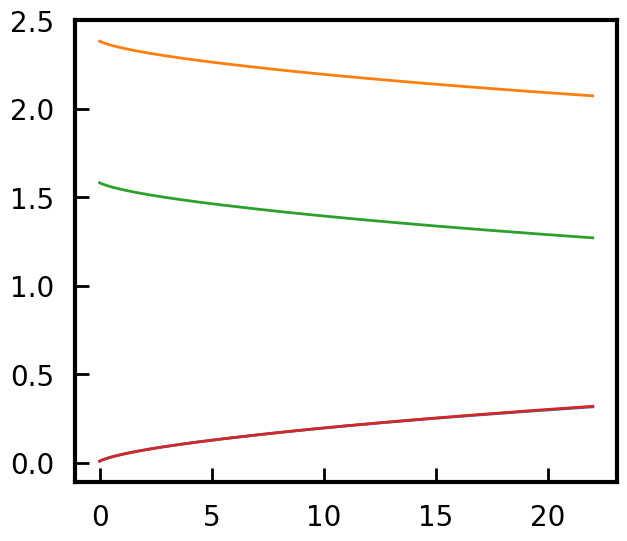

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import csv
%matplotlib inline

plt.rcParams['figure.figsize']=(7,6)
plt.rcParams['axes.linewidth'] = 3
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.major.width']=2
plt.rcParams['legend.edgecolor']='k'
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['xtick.major.pad'] = 15
plt.rcParams['ytick.major.pad'] = 15
plt.rcParams['legend.handletextpad']=0.4
plt.rcParams['legend.columnspacing']=0.5
plt.rcParams['legend.labelspacing']=0.3
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['axes.formatter.limits']=(-3, 6)

colormap=plt.cm.Dark2
colors = [colormap(i) for i in np.linspace(0, 1, 8)]

gs=gridspec.GridSpec(nrows=1, ncols=1)
gs.update(wspace=0.1)

ax0=plt.subplot(gs[0,0])

ax0.plot(increments,mole_fracs[:,0]*100,label='$\mathrm{H_2}$')
ax0.plot(increments,mole_fracs[:,1]*100,label='$\mathrm{H_2O}$')
ax0.plot(increments,mole_fracs[:,2]*100,label='$\mathrm{CO}$')
ax0.plot(increments,mole_fracs[:,3]*100,label='$\mathrm{CO_2}$')

H2(3)
C2H2(19)
C2H4(22)
C(53)
C3H6(58)
CX(5)
CHX(7)
C2H2X2(13)
CCH3X(16)
C3H3X2(40)
C3H3X2(48)


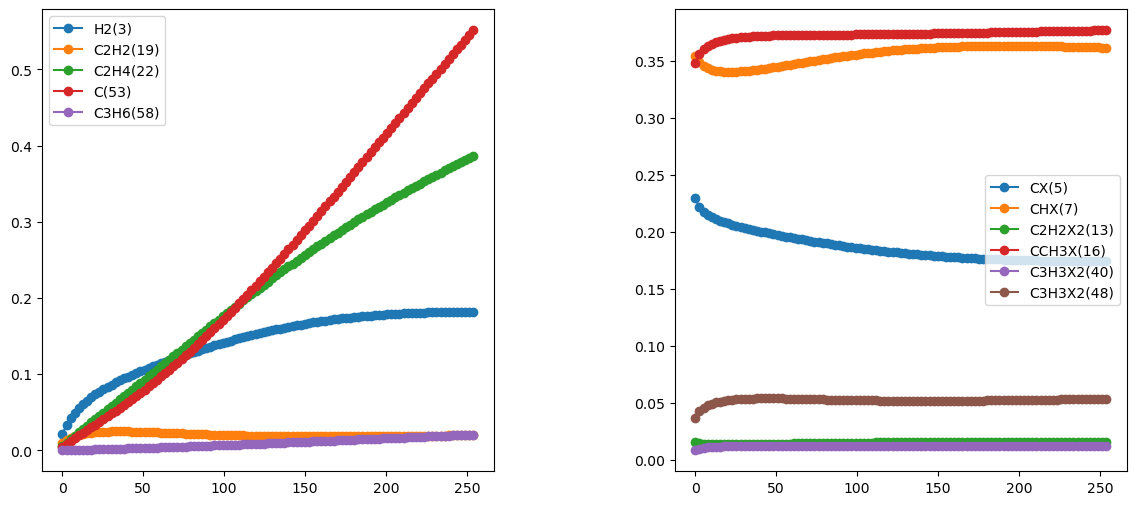

In [41]:
#Plot the most species with high concentration or high coverage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

colormap=plt.cm.Dark2
colors = [colormap(i) for i in np.linspace(0, 1, 8)]
#metal='Pt'
results=pd.read_csv(metal+'/cantera/simulation_results_w_covdep.txt', sep=",", header=0)  

import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize']=(14,6)
gs=gridspec.GridSpec(nrows=1, ncols=2)
gs.update(wspace=0.4, hspace=0.3)

ax0=plt.subplot(gs[0,0])
ax1=plt.subplot(gs[0,1])
for i in gas.species_names:
    if i=='N2':
        pass
    elif i=='C2H6(2)':
        pass
    elif any(results[str(i)]>1e-8):
        ax0.plot(results['x'],results[str(i)]*100,marker='o',label=i)
        print(i)
ax0.legend()


for i in surf.species_names:
    if any(results[str(i)]>1e-2):
        print(i)
        ax1.plot(results['x'],results[str(i)],marker='o',label=i)
ax1.legend()

In [69]:
#Reaction path analysis

import cantera as ct
import numpy as np
import pandas as pd
import os, sys

#######################################################################
# Input Parameters
#######################################################################
length = 25.4e-2  # Catalyst bed length in m
diameter=4e-3  #reactor diameter in m
volumetric_flow=20/60/1e6 #volumetric flow rate in m3/s 
cross_area=np.pi/4*diameter**2
pressure=1e5 #pressure
reactor_volume=length*cross_area
specific_cat_area = 4000  # Catalyst surface area in m^-1
tc=600

metal='Pt'

#input file containing the surface reaction mechanism
file='Pt/cantera/chem_covdep.yaml'
cti_file = file
t = tc + 273.15  # convert to Kelvin
gas = ct.Solution(cti_file, 'gas')
gas.TPX = t, pressure, 'N2:95, C2H6(2):5'

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = t, pressure
surf.coverages = {'X(1)':1}

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 101
dt = 1.0

####################################################################
rlen = length/(NReactors-1)
rvol = reactor_volume/(NReactors-1)

## catalyst area in one reactor
cat_area = rvol*specific_cat_area
mass_flow_rate =  volumetric_flow*gas.mean_molecular_weight*pressure/ct.gas_constant/273.15

TDY = gas.TDY
cov = surf.coverages
gas.TDY = TDY

r = ct.IdealGasReactor(gas, energy='off')
r.volume = rvol
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')

rsurf = ct.ReactorSurface(surf, r, A=cat_area)
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
v = ct.PressureController(r, downstream, master=m, K=1e-9)
    
sim = ct.ReactorNet([r])
sim.max_err_test_fails = 100

sim.rtol = 1.0e-12
sim.atol = 1.0e-24

mole_fracs=np.zeros((NReactors,gas.n_species))
coverages=np.zeros((NReactors,surf.n_species))
increments=np.zeros(NReactors)
for n in range(1):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY = r.thermo.TDY
        upstream.syncState()
        sim.reinitialize()
        sim.advance_to_steady_state()
        increments[n] = n * rlen * 1.0e3   # distance in mm 
        coverages[n,:]=surf.X
        mole_fracs[n,:]=gas.X
        
element = 'C'

diagram = ct.ReactionPathDiagram(surf, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
diagram.label_threshold = 1e-1
diagram.threshold = 1e-1
diagram.normal_threshold
diagram.get_dot()
diagram.font='CMU Serif'
diagram.show_details = True
diagram.flow_type='NetFlow'
diagram.dot_options='node[fontsize=40,shape="box"]'
    
dot_file = 'rxnpath-C-covdep-c2h4.dot'
modified_dot_file='rxnpath-C-covdep-c2h4-mod.dot'
img_file = 'rxnpath-C-covdep-c2h4.png'
img_path = os.path.join(os.getcwd(), img_file)
    
diagram.write_dot(dot_file)

os.system('dot {0} -Tpng -o {1} -Gdpi=100 -Nshape="box"  -Granksep=0.8 -Gmargin=0 -Gfixedsize=true -Gwidth=5'.format(dot_file, img_file)) 

 Sticking coefficient is greater than 1 for reaction 'C2H6(2) + 2 X(1) <=> C2H5X(14) + HX(12)'
 at T = 10000.0

 Sticking coefficient is greater than 1 for reaction 'C(53) + 2 X(1) <=> CH3X(21) + HX(12)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'C(53) + 2 X(1) <=> CH3X(21) + HX(12)'
 at T = 10000.0



0

In [60]:
#Compute selectivity, conversion, and reaction rate
import matplotlib.pyplot as plt
%matplotlib inline


import cantera as ct
import numpy as np
import pandas as pd

#######################################################################
# Input Parameters
#######################################################################

length = 25.4e-2  # Catalyst bed length in m
diameter=4e-3  #reactor diameter in m
volumetric_flow=20/60/1e6 #volumetric flow rate in m3/s 
cross_area=np.pi/4*diameter**2
pressure=1e5 #pressure
reactor_volume=length*cross_area
specific_cat_area = 4000  # Catalyst surface area in m^-1
tc=600

metal='Pt3Zn'

#input file containing the surface reaction mechanism
file=metal + '/cantera/chem_covdep.yaml'
cti_file = file
t = tc + 273.15  # convert to Kelvin
gas = ct.Solution(cti_file, 'gas')
gas.TPX = t, pressure, 'N2:95, C2H6(2):5'

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = t, pressure
surf.coverages = {'X(1)':1}

colormap=plt.cm.Dark2
colors = [colormap(i) for i in np.linspace(0, 1, 8)]

results=pd.read_csv(metal+'/cantera/simulation_results_w_covdep.txt', sep=",", header=0)  

import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize']=(14,6)
gs=gridspec.GridSpec(nrows=1, ncols=2)
gs.update(wspace=0.4, hspace=0.3)

n0_C2H6=7.3386024188618e-07

U=(n0_C2H6-results['C2H6(2)'][100]*results['n_total'][100])/n0_C2H6*100
r0=results['rate_C2H4'][0]
boring=['Ne','He','Ar','N2','C2H6(2)','H2(3)', 'H(7)']
interesting=[]
for i in gas.species_names:
    if i not in boring:
        interesting.append(i)
        
total_c=0
for i in interesting:
    print(i)
    total_c+=results[i][100]
    
for i in interesting:    
    if i.startswith('C2H4'):
        S_Pt_C2H4=results[i][100]/(total_c)*100
        
        
for i in interesting:    
    if i.startswith('C('):
        S_Pt_CH4=results[i][100]/(total_c)*100
        
print(S_Pt_C2H4, S_Pt_CH4, U, r0)

 Sticking coefficient is greater than 1 for reaction 'C2H6(2) + 2 X(1) <=> C2H5X(4) + HX(5)'
 at T = 10000.0

 Sticking coefficient is greater than 1 for reaction 'C(46) + 2 X(1) <=> CH3X(8) + HX(5)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'C(46) + 2 X(1) <=> CH3X(8) + HX(5)'
 at T = 10000.0

C2H4(12)
C(46)
C3H6(56)
61.460042124852244 36.83563900088914 2.95122062165844 1.0786030359997172e-09


In [36]:
#Get the enthalpies of CHCH3 on the specified metal
import cantera as ct
import numpy as np
import pandas as pd

#######################################################################
# Input Parameters
#######################################################################

length = 25.4e-2  # Catalyst bed length in m
diameter=4e-3  #reactor diameter in m
volumetric_flow=20/60/1e6 #volumetric flow rate in m3/s 
cross_area=np.pi/4*diameter**2
pressure=1e5 #pressure
reactor_volume=length*cross_area
specific_cat_area = 4000  # Catalyst surface area in m^-1
tc=25

metal='Pd3In'

#input file containing the surface reaction mechanism
file=metal + '/cantera/chem_covdep.yaml'
cti_file = file
t = tc + 273.15  # convert to Kelvin
gas = ct.Solution(cti_file, 'gas')
gas.TPX = t, pressure, 'N2:95, C2H6(2):5'

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = t, pressure
surf.coverages = {'X(1)':1}

idx=surf.species_index('C2H4X(11)')
enthalpy_CHCH3=surf.standard_enthalpies_RT[idx]*ct.gas_constant*gas.T/1e6
print(np.round(enthalpy_CHCH3,2))

 Sticking coefficient is greater than 1 for reaction 'C2H6(2) + 2 X(1) <=> C2H5X(4) + HX(5)'
 at T = 10000.0

 Sticking coefficient is greater than 1 for reaction 'C(48) + 2 X(1) <=> CH3X(10) + HX(5)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'C(48) + 2 X(1) <=> CH3X(10) + HX(5)'
 at T = 10000.0

-0.56


In [62]:
#Get the number of reactions with bidentate species in the mechanism
import cantera as ct
import numpy as np
import pandas as pd

#######################################################################
# Input Parameters
#######################################################################

length = 25.4e-2  # Catalyst bed length in m
diameter=4e-3  #reactor diameter in m
volumetric_flow=20/60/1e6 #volumetric flow rate in m3/s 
cross_area=np.pi/4*diameter**2
pressure=1e5 #pressure
reactor_volume=length*cross_area
specific_cat_area = 4000  # Catalyst surface area in m^-1
tc=600

metal='Pt'

#input file containing the surface reaction mechanism
file=metal + '/cantera/chem_covdep.yaml'
cti_file = file
t = tc + 273.15  # convert to Kelvin
gas = ct.Solution(cti_file, 'gas')
gas.TPX = t, pressure, 'N2:95, C2H6(2):5'

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = t, pressure
surf.coverages = {'X(1)':1}

bidentate_reactions=[]
for i in range(surf.n_reactions):
    educts=surf.reactants(i).split(' + ')
    for j in range(len(educts)):
        educt_spcs=educts[j].split(' ')
        for k in surf.species_names:
                if k.startswith(str(educt_spcs[-1])):
                    idx=surf.species_index(k)
                    s=surf.species(idx)
                    site = s.size
                    if site > 1:
                        bidentate_reactions.append(i)
                        
    prod=surf.products(i).split(' + ')
    for j in range(len(prod)):
        prod_spcs=prod[j].split(' ')
        for k in surf.species_names:
                if k.startswith(str(prod_spcs[-1])):
                    idx=surf.species_index(k)
                    s=surf.species(idx)
                    site = s.size
                    if site > 1:
                        bidentate_reactions.append(i)
                        
# to remove duplicated from list 
bidentate_reactions = list(set(bidentate_reactions)) 
print(len(bidentate_reactions))

 Sticking coefficient is greater than 1 for reaction 'C2H6(2) + 2 X(1) <=> C2H5X(14) + HX(12)'
 at T = 10000.0

 Sticking coefficient is greater than 1 for reaction 'C(53) + 2 X(1) <=> CH3X(21) + HX(12)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'C(53) + 2 X(1) <=> CH3X(21) + HX(12)'
 at T = 10000.0

594
